In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import json
from typing import Union
import sys

A regressor object was build. This uses gradient decent for training. Indeed other methods would be quicker such as
the Newton-Raphson (via second derivatives) but i thought i would keep it simple

This also allows you to return statistics on the predicted data vs the training data to check for drift

This also incorporates a l2 regularization

In [2]:

class LogisticReg:
    '''
    A class to perform a logistic regression using gradient descent

    Atributes
    ---------

    weights : np.array
        the model weights
    loss_tracker : list
        a list to track the loss during training
    epoc : list
        a list to track the epochs during training
    l2_mask : np.array
        an array to mask off the intercept weight if l2 reg is being used
    training_mean : np.array
        an array to keep the means of the variables used in training. This is used for normalization
        for training then prediction and also returning q values to monitor drift
    training_std : np.array
        an array to keep the std of the variables used in training. This is used for normalization
        for training then prediction and also returning q values to monitor drift

    Methods
    -------

    fit(self, x: np.array, y: np.array, lr: float =0.1, epochs: int =1000, l2_reg: float = 0) -> dict[str,list]:
        fits the model. Returns the loss and epochs for plotting

    predict(self, x: np.array, return_q: bool = False) -> np.array:
        predicts the class from the x array. Returns the probabilities and also the q_values for monitoring model
        drift.

    '''

    def __init__(self):

        self.weights = None
        self.loss_tracker = None
        self.epoc = None
        self.l2_mask = None
        self.training_mean = None
        self.training_std = None

    def get_sig(self, x: np.ndarray, w: np.ndarray) -> np.ndarray:
        '''Calculates the logistic function'''
        y = 1 / (1 + np.exp(-1 * np.matmul(x, w)))
        return y

    def calc_loss(self, x: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        '''Calculates the loss'''
        sigfn = self.get_sig(x, w)
        return np.mean(-y * np.log(sigfn) - (1 - y) * np.log(1 - sigfn))

    def get_grad(self, x: np.ndarray, y: np.ndarray, l2_reg: float = 0) -> np.ndarray:
        '''
        Calculates  the gradients
        l2_reg is used for l2 regularization. Uses  l2_reg*  0.5 * weights.T @ weights
        which differentiates to l2_reg*weights.
        the l2_mask masks off the intercept so this is not penalized
        '''

        gvec = 1 / x.shape[0] * (
                    np.matmul(x.T, (self.get_sig(x, self.weights) - y)) + l2_reg * self.weights * self.l2_mask)
        return gvec

    def fit(self, x: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 1000, l2_reg: float = 0) -> dict[str, list]:
        '''
        Info:
            Takes the X array and y array (targets) and fits a logistic regression. This can then be used with
            the predict method
        Parameters:
            x: np.array
            The np array of the explanatory variables. Must be shape [samples, features]
            y: np.array
            The np array of the targets. These must be in {0,1}. Must have shape [samples, 1]
            lr: float
            The learning rate for the gradient decent
            epochs: int
            Number of epochs to go through
            l2_reg: float
            The l2 penalty to put on the weights
        Returns:
            Dictionary of 'loss': list and 'epochs': list
            This is for monitoring the loss over the epochs during training
        Effects:
            Updates self.weights for use in predict
            Updates self.training_mean for use in predict
            Updates self.training_std for use in predict
        '''

        assert x.shape[0] == y.shape[0], f"x and y must be the same shape. Recieved x: {x.shape}, y: {y.shape}"

        self.training_mean = np.mean(x, axis=0)
        self.training_std = np.std(x, axis=0)

        x = (x - self.training_mean) / self.training_std  # Normalizes the data

        x = np.column_stack((x, np.ones(x.shape[0])))  # Adds on a 1 for the intercept

        x_rows = x.shape[0]
        x_cols = x.shape[1]

        self.loss_tracker = []
        self.epoc = []
        self.weights = np.random.uniform(0, 1, x_cols).reshape(x_cols, 1)  # Initialize weights  randomly
        l2_mask = np.ones_like(self.weights)
        l2_mask[-1] = 0
        self.l2_mask = l2_mask  # A mask for l2 reg which stops the intercept being penalized

        for i in range(epochs):
            self.weights += -lr * self.get_grad(x, y, l2_reg)

            loss = self.calc_loss(x, y, self.weights)
            self.loss_tracker.append(loss)
            self.epoc.append(i)

        return {'loss': self.loss_tracker, 'epochs': self.epoc}

    def predict(self, x: np.ndarray, return_q: bool = False,
                binary: bool = True) -> Union[dict[str, np.ndarray], np.ndarray]:
        '''
        Info:
        Makes predictions given the x input features and returns prediction probabilities
        Parameters:
            x: np.array
            The np array of the input parameters
            return_q: bool
            whether to return the qvalues for use in model tracking
            binary: bool
            whether to return binary predictions (True) or probabilities (False)
        Returns:
            dict:
            dictionary of 'predictions': np.array, the probability  of class 1 and
            'q_values': Union[np.array, None], the q values for the predicted data

        Effects:
            None
        '''

        assert self.weights is not None, "No weights found. Please fit a model first"
        assert x.shape[-1] == self.training_mean.shape[-1], f"x must have {self.training_mean.shape[-1]} variables"

        q_values = None

        if return_q:
            q_values = (x - self.training_mean) / self.training_std

        x = (x - self.training_mean) / self.training_std  # Normalizes the data in the same way as training

        x = np.column_stack((x, np.ones(x.shape[0])))  # Adds ones for the intercept

        if binary:
            return (self.get_sig(x, self.weights) >= 0.5).astype(int)
        return {'predictions': self.get_sig(x, self.weights), 'q_values': q_values}

    def dump(self) -> dict:
        ''' Dumps details for re-initialization'''
        details = {
            'weights': self.weights.tolist(),
            'loss_tracker': self.loss_tracker,
            'epoc': self.epoc,
            'l2_mask': self.l2_mask.tolist(),
            'training_mean': self.training_mean.tolist(),
            'training_std': self.training_std.tolist(),
        }
        return details

    def load(self, weights, loss_tracker, epoc, l2_mask, training_mean, training_std):
        '''loads a model based on the provided metrics from **self.dump()'''
        self.weights = np.array(weights)
        self.loss_tracker = loss_tracker
        self.epoc = epoc
        self.l2_mask = np.array(l2_mask)
        self.training_mean = np.array(training_mean)
        self.training_std = np.array(training_std)



Lets look at the raisin data now and perform the regression

In [3]:
# Read in the raisin data now

raisin_df = pd.read_csv('Raisin_Dataset.csv')

# Just  take the variables

x_df = raisin_df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter']]

x_df.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


In [4]:
# Map the targets to binary classes

raisin_df['Bin_Class'] = raisin_df['Class'].map(lambda x: {'Kecimen':1,'Besni':0}[x])

print('Binary Classes\n')
print(raisin_df.value_counts('Bin_Class'))
print('\nnamed classes\n')
print(raisin_df.value_counts('Class'))


Binary Classes

Bin_Class
0    450
1    450
Name: count, dtype: int64

named classes

Class
Besni      450
Kecimen    450
Name: count, dtype: int64


In [5]:
# Convert the data to numpy

x_numpy = x_df.to_numpy()

y_numpy = raisin_df['Bin_Class'].to_numpy().reshape(-1,1)


Perform the regression

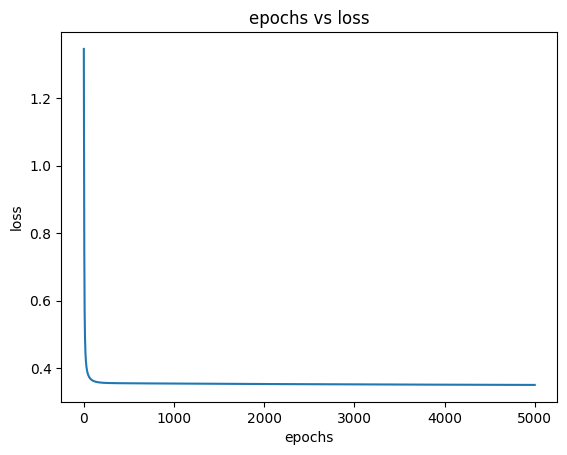


Confusion matrix for custom model



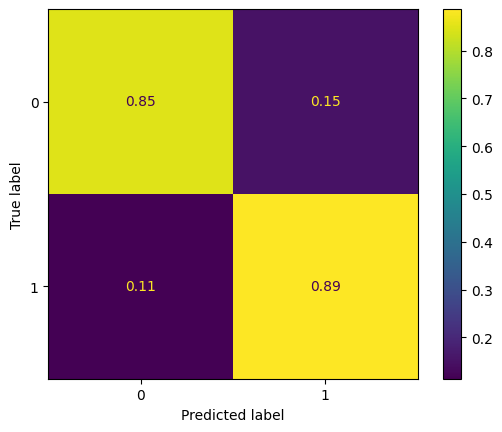

In [6]:

raisin_reg = LogisticReg()

metrics = raisin_reg.fit(x_numpy,y_numpy,epochs=5000)

plt.plot(metrics['epochs'],metrics['loss'])
plt.title('epochs vs loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

prd = raisin_reg.predict(x_numpy,return_q=True, binary = False)
print('\nConfusion matrix for custom model\n')
cm = confusion_matrix(y_numpy , prd['predictions']>0.5, normalize='true' )

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Testing dump and load feature

In [7]:

with open("/Users/ben/Desktop/PyProjects/fastapi_docker/raisin_model.json", "w") as f:
    json.dump(raisin_reg.dump(), f)

with open("/Users/ben/Desktop/PyProjects/fastapi_docker/raisin_model.json", 'r') as f:
    reloaded_data = json.load(f)

re_loaded_mod = LogisticReg()
re_loaded_mod.load(**reloaded_data)
prd = re_loaded_mod.predict(x_numpy, return_q=True, binary=False)
print('\nConfusion matrix\n')
print(confusion_matrix(y_numpy, prd['predictions']>0.5, normalize='true' ))



Confusion matrix

[[0.84888889 0.15111111]
 [0.11333333 0.88666667]]


Will test out the fast API now! 

In [19]:
body = {'Area': [87524, 75166],
 'MajorAxisLength': [442.2460114, 406.690687],
 'MinorAxisLength': [253.291155, 243.0324363],
 'Eccentricity': [0.819738392, 0.801805234],
 'ConvexArea': [90546, 78789],
 'Extent': [0.758650579, 0.68412957],
 'Perimeter': [1184.04, 1121.786]}
 
response = requests.post("http://127.0.0.1/predict/", json=body).json()

print(response)

{'predictions': [[0.35195471524102434], [0.5189776433759058]], 'q_values': [[-0.007186368228293334, 0.09757694726280954, -0.023958186812480693, 0.4231416366814646, -0.015709027557133555, 1.1067426378437466, 0.06627396602471022], [-0.3242171863419545, -0.2090120720145583, -0.2292922188022519, 0.22447639014727822, -0.3042481970320827, -0.28777679036133497, -0.1612524532199187]]}


In [16]:
import requests

data_dict = x_df.to_dict(orient='list') 
response = requests.post("http://127.0.0.1/predict/", json=data_dict).json()

print('\nConfusion matrix\n')
print(confusion_matrix(y_numpy , np.array(response['predictions'])>0.5, normalize='true' ))



Confusion matrix

[[0.84666667 0.15333333]
 [0.11111111 0.88888889]]


Now will test it against the out of the box regressor.

As you can see the performances are very similar!

Confusion Matrix for Sklearn model


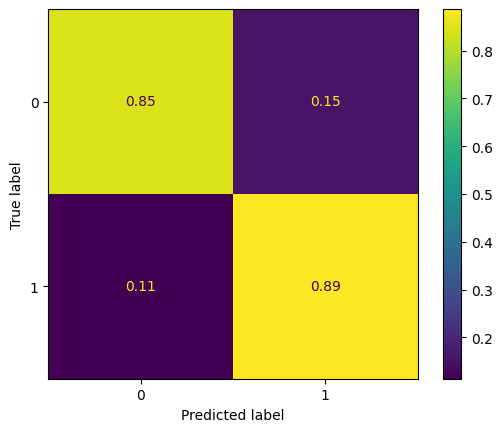

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True)

x_normalized = (x_numpy - np.mean(x_numpy,axis=0)) / np.std(x_numpy,axis=0)
model.fit(x_normalized, y_numpy.ravel())

cm = confusion_matrix(y_numpy , model.predict(x_normalized) , normalize='true' )
print('Confusion Matrix for Sklearn model')
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()



Now lets look at the variable contributions using shaply

In [10]:
import shap

explainer =  shap.Explainer(raisin_reg.predict,x_numpy)


/opt/miniconda3/envs/logreg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
shap_values = explainer(x_numpy)

In [12]:
shap_values.feature_names = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter']


As we can see perimeter is the most important feature

Extent is the least

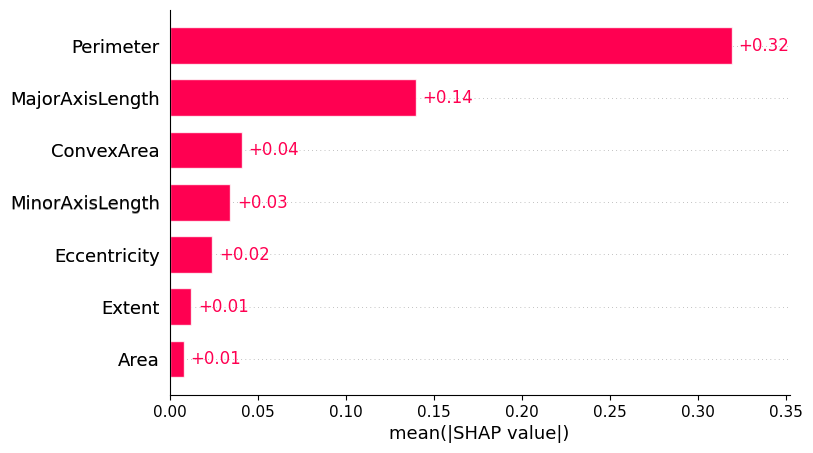

In [13]:
shap.plots.bar(shap_values)

As we can see, perimeter is  the most important feature. So the lower the perimeter, the more likely it is to be 

class 1, kecimin


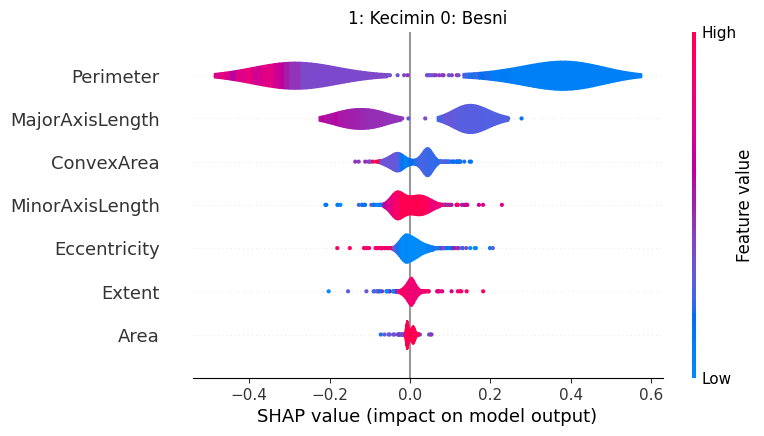

In [14]:
shap.summary_plot(shap_values, plot_type='violin',show=False)
plt.title('1: Kecimin 0: Besni')
plt.show()


So for clarity, lets look at the histograms of the most important feature, Perimeter

As we can see, Besni (Class  0) tends to have a larger perimeter


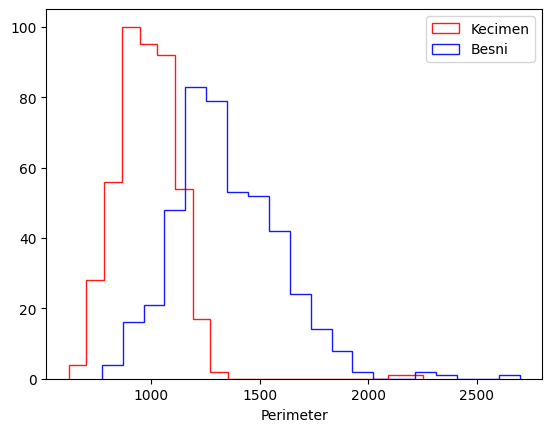

In [15]:

plt.hist(raisin_df['Perimeter'][raisin_df['Class']=='Kecimen'],histtype='step',bins=20,edgecolor='red',alpha=0.9,label='Kecimen')
plt.hist(raisin_df['Perimeter'][raisin_df['Class']=='Besni'],histtype='step',bins=20,edgecolor='blue',alpha=0.9, label='Besni')
plt.xlabel('Perimeter')
plt.legend()
plt.show()